I decided, for my first post, to introduce and get familiar with the dataset that I plan to use for future learning and insight, which is basically all the offensive NFL statistics I could find. It’s a big enough dataset that you can potentially get insight from it, but not fully comprehensive of what a professional football game is as a whole. There are a few intentional decisions that I made when thinking about what I wanted out of this dataset.
1. I’m really only looking at specific offensive statistics and excluding kickoff return stats, for example.
2. Neglecting defensive statistics - I may decide to include these going forward, but I generally group these stats by position, and there are a lot of positions on defense.
3. I’m only tracking current players - the only benefit past player’s stats would give might be a coach’s specific tendencies, but I think those insights would be limited, at best.


In [1]:
from bs4 import BeautifulSoup
import pandas as pd
from urllib import request
import re
import os
import sqlite3
import matplotlib.pyplot as plt
% matplotlib inline
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

I created a SQLite DB from web scraping, with different tables for each position. Initially, I took a look at just QB data and the initial stat correlations.

In [2]:
query = 'SELECT * FROM qbs'
conn = sqlite3.connect('nfl_db.sqlite')
c = conn.cursor()
c.execute(query)
qb_df = pd.DataFrame(c.fetchall())
qb_df.columns = [desc[0] for desc in c.description]
qb_df.head()

,date,team,opponent,result,attempts,completions,percent,yards,yards_per_attempt,touchdowns,interceptions,longest_completion,sacks,qb_rating,player_name
0,08/11/16,Jax,@ NYJ,"L, 17-13",19,10,52.6,138,7.3,0,1,27,1/10,54.3,brandon allen
1,08/20/16,Jax,TB,"L, 27-21",3,0,0.0,0,0.0,0,1,0,0/0,0.0,brandon allen
2,09/01/16,Jax,@ Atl,"L, 17-15",26,17,65.4,164,6.3,2,1,25t,2/18,92.5,brandon allen
3,08/26/16,Car,NE,"L, 19-17",9,5,55.6,37,4.1,0,1,18,0/0,25.9,derek anderson
4,09/25/16,Car,Min,"L, 22-10",1,1,100.0,3,3.0,0,0,3,0/0,79.2,derek anderson


Some of the columns clearly need cleaning up. Notably, the longest completion column contains ints and strings, and I'd like to track season trends by month, so dates need to be converted to months. Additionally, results can be segregated into W/L, and the teams score. Sacks can be separated into number of sacks and sack yardage, but sacks are a consequence of a lot of different factors that largely I don't believe to be related to QB performance. 

First, we need to define the functions to use for standardizing columns. These will then be applied through a lambda function and assigned to new column.

In [3]:
def longest_fix(x):
    try:
        if x[-1] == 't':
            return int(x[:-1])
    except:
        return int(x)

In [4]:
def month_fix(x):
    if x < 3:
        x = 12 + x
    return x - 7

In [5]:
def winloss_fix(x):
    return int(x.split(',')[0] == 'W')

In [6]:
def score_fix(x):
    win_loss = x.split(',')[0]
    if win_loss == 'W':
        return x.split(',')[1].split('-')[0]
    return x.split(',')[1].split('-')[1]

After defining the fixes previously described, we need to apply the functions to the dataset and either append them to the DataFrame, or replace the columns with the fixed columns:

In [7]:
qb_df['date'] = pd.to_datetime(qb_df.date, format="%m/%d/%y")
qb_df['score'] = qb_df.result.apply(lambda x: score_fix(x))
qb_df['win_loss'] = qb_df.result.apply(lambda x: winloss_fix(x))
qb_df['month'] = qb_df.date.apply(lambda x: month_fix(x.month))
qb_df['longest_completion'] = qb_df.longest_completion.apply(lambda x: longest_fix(x))

As many of the stats within the dataset are encapsulated within the Quarterback Rating, it makes sense to use that to look at the matchups and locations that produce the highest and lowest QBRs. First, however, we'll have to normalize the QBRs by the average QBR of each quarterback to ascertain absolute performance.

In [8]:
average_qb_rating = []
for name in qb_df.player_name.values:
    average_qb_rating.append(qb_df[qb_df.player_name == name].qb_rating.mean())
qb_df['average_qb_rating'] = average_qb_rating
qb_df['norm_rating'] = qb_df.qb_rating/qb_df.average_qb_rating

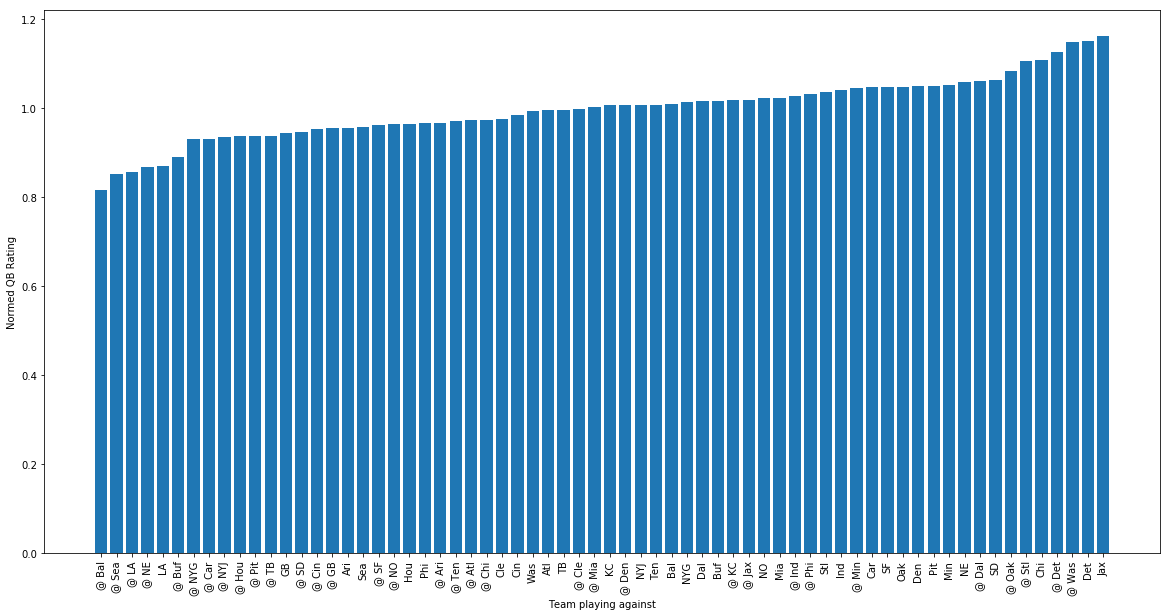

In [16]:
temp_df = qb_df.groupby('opponent').norm_rating.mean().sort_values()
plt.figure(figsize=(20,10))
plt.bar(range(66), temp_df.values)
plt.xticks(range(66), temp_df.index, rotation=90)
plt.ylabel('Normed QB Rating')
plt.xlabel('Team playing against')
plt.show()

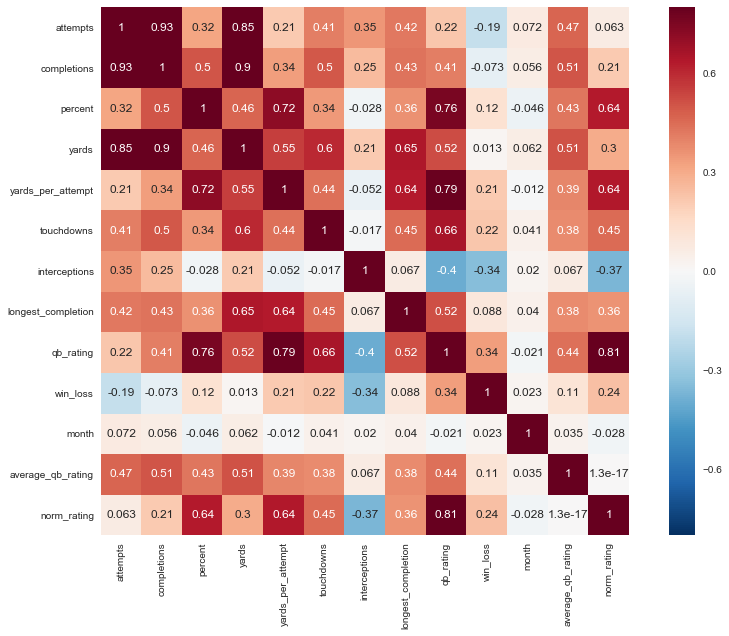

In [17]:
import seaborn as sns
corrmat = qb_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True)
f.tight_layout()

In [18]:
query = 'SELECT * FROM qbs'
conn = sqlite3.connect('nfl_db.sqlite')
c = conn.cursor()
c.execute(query)
qb_df2 = pd.DataFrame(c.fetchall())
qb_df2.columns = [desc[0] for desc in c.description]
qb_df2.head()

,date,team,opponent,result,attempts,completions,percent,yards,yards_per_attempt,touchdowns,interceptions,longest_completion,sacks,qb_rating,player_name
0,08/11/16,Jax,@ NYJ,"L, 17-13",19,10,52.6,138,7.3,0,1,27,1/10,54.3,brandon allen
1,08/20/16,Jax,TB,"L, 27-21",3,0,0.0,0,0.0,0,1,0,0/0,0.0,brandon allen
2,09/01/16,Jax,@ Atl,"L, 17-15",26,17,65.4,164,6.3,2,1,25t,2/18,92.5,brandon allen
3,08/26/16,Car,NE,"L, 19-17",9,5,55.6,37,4.1,0,1,18,0/0,25.9,derek anderson
4,09/25/16,Car,Min,"L, 22-10",1,1,100.0,3,3.0,0,0,3,0/0,79.2,derek anderson


In [19]:
qb_df2.longest_completion = qb_df2.longest_completion.apply(lambda x: completion_fix(x))
qb_df2.date = pd.to_datetime(qb_df2.date, format="%m/%d/%y")

NameError: name 'completion_fix' is not defined

In [ ]:
average_qb_rating = []
for name in qb_df.player_name.values:
    average_qb_rating.append(qb_df[qb_df.player_name == name].qb_rating.mean())
qb_df['average_qb_rating'] = average_qb_rating
qb_df['norm_rating'] = qb_df.qb_rating/qb_df.average_qb_rating
temp_df = qb_df.groupby('opponent').norm_rating.mean().sort_values()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(range(66), temp_df.values)
plt.xticks(range(66), temp_df.index, rotation=90)
plt.ylabel('Normed QB Rating')
plt.xlabel('Team playing against')
plt.show()

In [ ]:
win_loss = (qb_df2.result.apply(lambda x: x.split(',')[0]) == 'W').astype(int)
qb_df2['win_loss'] = win_loss

In [ ]:
corrmat = qb_df2.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True)
f.tight_layout()

In [ ]:
query = 'SELECT * FROM rbs'
conn = sqlite3.connect('nfl_db.sqlite')
c = conn.cursor()
c.execute(query)
rb_df = pd.DataFrame(c.fetchall())
rb_df.columns = [desc[0] for desc in c.description]
rb_df.head()

In [ ]:
def score_extraction(x):
    win_loss, scores = x.split(',')
    if win_loss == 'W':
        return int(scores.split('-')[0])
    return int(scores.split('-')[1])

In [ ]:
rb_df.rushing_long = rb_df.rushing_long.apply(lambda x: completion_fix(x))
rb_df.reception_long = rb_df.reception_long.apply(lambda x: completion_fix(x))
rb_df.date = pd.to_datetime(qb_df2.date, format="%m/%d/%y")
win_loss = (rb_df.result.apply(lambda x: x.split(',')[0]) == 'W').astype(int)
score = (rb_df.result.apply(lambda x: score_extraction(x))).astype(int)
rb_df['score'] = score
rb_df['win_loss'] = win_loss
rb_df.drop('id', axis=1, inplace=True)

In [ ]:
corrmat = rb_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True)
f.tight_layout()

In [ ]:
from bokeh.plotting import figure, show
month = rb_df.date.apply(lambda x: x.month)
month = month.apply(lambda x: month_manip(x))
rb_df['month'] = month

month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February']
rypa = []
for m in rb_df.month.unique():
    if m != np.nan:
        rypa.append(rb_df.rushing_yards_per_attempt[rb_df.month == m].mean())
        
p = figure(plot_width=500, plot_height=500, x_range=month_names)
p.xaxis.axis_label = "Month"
p.yaxis.axis_label = "Average Rushing Yards per Attempt"
r = p.line(list(range(1,13)), rypa)
t = show(p, notebook_handle=True)

In [ ]:
normed_rypa = []
for name in rb_df.player_name:
    normed_rypa.append(rb_df.rushing_yards_per_attempt[rb_df.player_name == name].mean())
rb_df['normed_rushing_YPA'] = normed_rypa
rypa = []
for m in range(1,8):
    rypa.append(rb_df.normed_rushing_YPA[rb_df.month == m].mean())
        
p = figure(plot_width=500, plot_height=500, x_range=month_names)
p.xaxis.axis_label = "Month"
p.yaxis.axis_label = "Normed Average Rushing Yards per Attempt"
r = p.line(list(range(1,13)), rypa)
t = show(p, notebook_handle=True)

Adjusting the rushing yards per attempt, there is a slight difference in rushing yards per attempt throughout the season, but not all that much of a difference. Let's look at rushing attempts now, to see if coaches are more prone to giving running backs more or less attempts throughout the season.

In [ ]:
normed_attempts = []
for name in rb_df.player_name:
    normed_attempts.append(rb_df.rushing_attempts[rb_df.player_name == name].mean())
rb_df['normed_attempts'] = normed_attempts

rushing_attempt_average = []
for m in range(1,8):
    rushing_attempt_average.append(rb_df.normed_attempts[rb_df.month == m].mean())

p = figure(plot_width=500, plot_height=500, x_range=month_names)
p.xaxis.axis_label = "Month"
p.yaxis.axis_label = "Rushing Attempts"
r = p.line(list(range(1,13)), rushing_attempt_average)
t = show(p, notebook_handle=True)

There is actually a fairly significant number more attempts given to running back in August as opposed to the rest of the season.